In [1]:
from src.thickness_dataset import ThicknessDataset, ToTensor
from src.models import U_Net
from src.trainer import Trainer

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

PATH = "data\gen_data_6000_v2"

In [2]:
augs = A.Compose([A.Normalize(mean = (0, 0, 0),
                              std  = (1, 1, 1)),
                 ToTensorV2()])
thickness_dataset = ThicknessDataset(PATH, transform=augs)

# Calculate mean and std
image_loader = DataLoader(thickness_dataset, 
                          batch_size  = 128, 
                          shuffle     = False, 
                          num_workers = 4,
                          pin_memory  = True)

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs['img'].sum(axis        = [0, 2, 3])
    psum_sq += (inputs['img'] ** 2).sum(axis = [0, 2, 3])

# pixel count
count = len(thickness_dataset) * 128 * 128

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

100%|██████████| 52/52 [00:28<00:00,  1.82it/s]


In [3]:
from torch.utils.data import DataLoader, Subset

def customRandomSplit(dataset, train_size, val_size, test_size):
    # TODO: DONT think its adding in the indices +1 and +2 need to add that to all the indices arrays
    rnd_Seed=42
    mandatory_test_models = ["88d183f319cddb7344221bef0fa3c36b","ce40b134b11e8c822bbc2c380e91dfe2","67bc9bec05f78850f9e08161aea27d2f","ba494b33be3a3e0dc1bbb501b1d87871","15cc3d9020384e8d6e09a8e31c7575c5","bc6a3fa659dd7ec0c62ac18334863d36","46dbba829a57ace8cffd61677456447e","1d527bbed4d12817fa3bb91f4e3cd35f","f400eb5421283e8a102f4912aece242b","899af991203577f019790c8746d79a6f"]
    data_len = len(dataset)
    train_size = int(round((train_size * data_len)/3))
    val_size   = int(round((val_size * data_len)/3))
    test_size  = int(round((test_size * data_len)/3))

    assert train_size*3 + val_size*3 + test_size*3 == data_len, "The split sizes do not add up to the dataset size"
    # Using pytorch subsets to split the dataset
    # 3 is the number of frames per model
    # randomly sample indices for the train size
    choices = np.arange(0, data_len, 3, dtype=int)
    # get the index numbers for the mandatory test models from dataset dataframe
    mandatory_test_indices = []
    for i in range(len(mandatory_test_models)):
        mandatory_test_indices.append(dataset.dataframe[dataset.dataframe["model_id"] == mandatory_test_models[i]].index[0])
    mandatory_test_indices = np.array(np.array(mandatory_test_indices), dtype=int)
    # remove the values in mandatory_test_indices from the choices
    choices = np.setdiff1d(choices, mandatory_test_indices)
    
    np.random.seed(rnd_Seed)
    np.random.shuffle(choices)
    # randomly sample indices for the train size
    train_indices = choices[:train_size]
    # randomly sample indices for the val size
    val_indices = choices[train_size:train_size+val_size]
    # randomly sample indices for the test size
    test_indices = choices[train_size+val_size:train_size+val_size+test_size]
    # add the mandatory test indices to the test indices
    test_indices = np.concatenate((test_indices, mandatory_test_indices))
    # final check the values in mandatory_test_indices are in test_indices
    assert np.all(np.isin(mandatory_test_indices, test_indices)), "The mandatory test indices are not in the test indices"
    # check mandatory_test_indices values arent in the other 2
    assert np.all(np.isin(mandatory_test_indices, train_indices)) == False, "The mandatory test indices are in the train indices"
    assert np.all(np.isin(mandatory_test_indices, val_indices)) == False, "The mandatory test indices are in the val indices"


    train_indices = np.concatenate((train_indices, train_indices+1, train_indices+2))
    val_indices = np.concatenate((val_indices, val_indices+1, val_indices+2))
    test_indices = np.concatenate((test_indices, test_indices+1, test_indices+2))
    # no intersections between the sets
    it = np.intersect1d(train_indices, val_indices)
    it2 = np.intersect1d(train_indices, test_indices)
    it3 = np.intersect1d(val_indices, test_indices)
    assert len(it) == 0 , f"The train and val sets have the same indices {it}"
    assert len(it2) == 0 , f"The train and test sets have the same indices {it2}"
    assert len(it3) == 0 , f"The val and test sets have the same indices{it3}"
    
    # create the subsets
    train_set = Subset(dataset, train_indices)
    val_set   = Subset(dataset, val_indices,)
    test_set  = Subset(dataset, test_indices)
    assert len(train_set) + len(val_set) + len(test_set) == data_len, "The split sizes do not add up to the dataset size"
    return train_set, val_set, test_set

In [11]:
augs = A.Compose([A.Normalize(mean = total_mean,
                              std  = total_std),
                 ToTensorV2()])
thickness_dataset_without_big = ThicknessDataset(PATH, mode=1, transform=augs)
thickness_dataset_only_big = ThicknessDataset(PATH, mode=2, transform=augs)
print("Number of samples in dataset without large object", len(thickness_dataset_without_big))
print("Number of samples in dataset with only large objects", len(thickness_dataset_only_big))

train_split = 0.9
valid_split = 0.1
train_size = int(train_split * len(thickness_dataset_without_big))+1
valid_size = int(valid_split * len(thickness_dataset_without_big))


train_dataset, valid_dataset = torch.utils.data.random_split(thickness_dataset_without_big, [train_size, valid_size], generator=torch.Generator().manual_seed(42))

test_dataset = thickness_dataset_only_big

batch_size = 16 # 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=128)

print("Number of batches in train dataset", len(train_dataset))
print("Number of batches in valid dataset", len(valid_dataset))
print("Number of batches in test dataset", len(test_dataset))

Number of samples in dataset without large object 5514
Number of samples in dataset with only large objects 1038
Number of batches in train dataloader 4963
Number of batches in valid dataloader 551
Number of batches in test dataloader 1038


In [5]:
no_of_batch =0
depth_sum = torch.zeros(1,128,128)
for batch in train_dataloader:
    # Get the depth maps for the batch
    thick_map = batch["thick_map"]
    # Accumulate the sum of depth maps and the number of pixels
    depth_sum += torch.mean(thick_map, dim=0)
    no_of_batch +=1
# Calculate the mean depth over all batches
mean_depth = depth_sum / no_of_batch
# show the mean depth in a graph
print("Mean depth over all batches:", mean_depth)

Mean depth over all batches: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


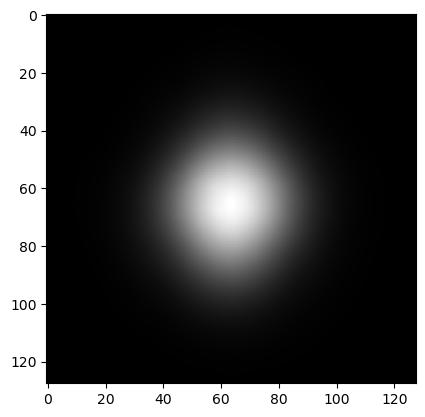

In [6]:
plt.imshow(mean_depth[0], cmap="gray")

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [8]:
# Get the masked loss for the test set quantative evaluation 
# https://torchmetrics.readthedocs.io/en/stable/image/peak_signal_noise_ratio.html
import copy
from skimage.metrics import structural_similarity as ssim
from src.evaluation import mse_loss_with_nans, mse_loss_with_nans_with_extras
mse_full_loss = 0
mmse_full_loss = 0
mmse_full_loss_extr = 0

batches = 0
catagory_losses = {}
loss_fn = torch.nn.MSELoss()
with torch.no_grad():
    for data in test_dataloader:
        labels = data['thick_map'].to(device, dtype=torch.float)
        catagory_id = data['catagory_id']


        outputs = torch.ones(labels.shape[0], 1, 128, 128).to(device, dtype=torch.float)
        outputs = outputs * mean_depth.to(device, dtype=torch.float)

        mse_loss = loss_fn(outputs, labels)
        masked_lossv0 = mse_loss_with_nans(outputs, labels)
        masked_lossv1, losses = mse_loss_with_nans_with_extras(outputs, labels)

        # using the catagory id to keep adding the loss to the scores
        for i in range(losses.shape[0]):
            if catagory_id[i] in catagory_losses:
                catagory_losses[catagory_id[i]].append(losses[i].cpu().numpy())
            else:
                catagory_losses[catagory_id[i]] = [losses[i].cpu().numpy()]

        mse_full_loss += mse_loss.item()
        mmse_full_loss += masked_lossv0
        mmse_full_loss_extr += masked_lossv1
        batches += 1
print("Test MSE loss: {}".format(mse_full_loss/batches))
print("Test MMSE loss: {}".format(mmse_full_loss/batches))
print("Test MMSE loss with extras: {}".format(mmse_full_loss_extr/batches))

Test MSE loss: 0.0024292757087904546
Test MMSE loss: 0.01655934564769268
Test MMSE loss with extras: 0.01655934564769268


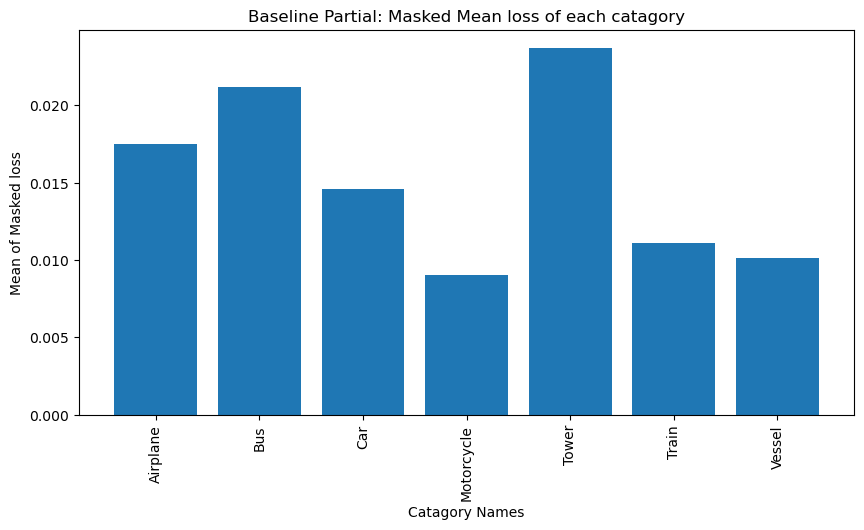

In [9]:
# for each catagory calculate the mean then plot a bar graph of the mean loss of each catagory
catagory_mean_losses = {}
for catagory in catagory_losses:
    catagory_mean_losses[catagory] = np.mean(catagory_losses[catagory])
fig = plt.figure(figsize=(10, 5))
plt.title("Baseline Partial: Masked Mean loss of each catagory")
plt.xlabel("Catagory Names")
plt.ylabel("Mean of Masked loss")
    # change the xticks rotate the labels 90 degrees
plt.bar(catagory_mean_losses.keys(), catagory_mean_losses.values())
plt.xticks(rotation=90)
# using thickness_dataset.labels to get the catagory name strings for the xticks
plt.xticks(list(catagory_mean_losses.keys()), [thickness_dataset.labels[i].split(',')[0].capitalize() for i in catagory_mean_losses.keys()])


plt.show()
# save as pdf
fig.savefig("figs\\partial\\baseline_mean_loss_of_each_catagory.pdf", bbox_inches='tight')
